### Extract peak, max and min freq.

Early test. The most useful part is the 'calc_dbfs_spectrum()' function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wf
from scipy.signal import blackmanharris

In [2]:
# Settings.
self_window_size = 8192
self_window_size = 4096
self_window_size = 2048
self_window_size = 1024
self_window_size = 512
self_window_size = 256
#self_window_size = 128
#self_window_size = 64
#self_window_size = 32

wave_file_path = 'in_data/myotis_plecotus_eptesicus_TE384.wav'


In [3]:
# Related to settings only.
self_hamming_window = np.hamming(self_window_size)
self_hamming_dbfs_max = np.sum(self_hamming_window) / 2 # Max db value in window. DBFS = db full scale. Half spectrum used.
self_blackmanharris_window = blackmanharris(self_window_size)
self_blackmanharris_dbfs_max = np.sum(self_blackmanharris_window) / 2 # Max db value in window. dbFS = db full scale. Half spectrum used.

In [4]:
# 
def calc_dbfs_spectrum(signal, window_function, dbfs_max):
    signal = signal * window_function
    spectrum = np.fft.rfft(signal)
    dbfs_spectrum = 20 * np.log10(np.abs(spectrum) / dbfs_max)
    return dbfs_spectrum


In [5]:
# File.
self_sampling_frequency, signal_buffer_int16 = wf.read(wave_file_path)
signal_buffer = signal_buffer_int16 / 32768 # From singed int16 to [-1.0, 1.0]

self_freq_bins = np.arange((self_window_size / 2) + 1) / (self_window_size / self_sampling_frequency)

self_signal_length = len(signal_buffer)
print(self_signal_length)

9216000


In [6]:
start_sec = 45.0
stop_sec = 46.0
#start_sec = 101.0
#stop_sec = 105.1
#start_sec = 3*60.0 + 8.0
#stop_sec = 3*60.0 + 10.0

step_size_ms = 0.05
#step_size_ms = 0.2 # Used for zero-crossing.

step = int(start_sec * self_sampling_frequency)
stop_step = int(stop_sec * self_sampling_frequency)
#step_size = int(self_sampling_frequency / 500)
step_size = int(self_sampling_frequency / (100 / step_size_ms))
print(step_size)

dbmax=0
dbmax_old=0

19


In [7]:
pulse_active = False

result_x_sec = []
result_y_max = []
result_y_peak = []
result_y_minfr = []
result_y_maxfr = []

dbfs_spectrum = calc_dbfs_spectrum(signal_buffer[step:step+self_window_size], 
                                   self_blackmanharris_window, self_blackmanharris_dbfs_max)
dbmax_old=np.max(dbfs_spectrum)
dbmax=np.max(dbfs_spectrum)

#while (step+self_window_size*2) < self_signal_length:
#while (step+self_window_size*2) < 2000000:
while step < stop_step:
    
    if abs(dbmax_old - dbmax) > 15:
        if dbmax_old < dbmax: pulse_active = True
        if dbmax_old > dbmax: pulse_active = False
        dbmax_old = dbmax
        
    if pulse_active:
        sec = step / self_sampling_frequency
        bin_peak_index = dbfs_spectrum.argmax()
        peak_frequency_hz = bin_peak_index * self_sampling_frequency / self_window_size *10 # 10=TE
        min_fr = peak_frequency_hz
        max_fr = peak_frequency_hz
        peak_db = dbfs_spectrum[bin_peak_index]
        #dbfs_spectrum_boolean = np.where(dbfs_spectrum > (peak_db - 40), True, False)
        #dbfs_spectrum_boolean = np.where(dbfs_spectrum > (-60), True, False)
        
        test = np.nonzero(dbfs_spectrum > (-55))
        if len(test[0]) > 0:
            index_min = test[0][0]
            index_max = test[0][-1]
            min_fr = index_min * self_sampling_frequency / self_window_size * 10
            max_fr = (index_max) * self_sampling_frequency / self_window_size * 10
        
        #for index_min, value in enumerate(dbfs_spectrum_boolean):
        #    if value == True:
        #        min_fr = index_min * self_sampling_frequency / self_window_size * 10
        #        break
        #for index_max, value in enumerate(dbfs_spectrum_boolean[index_min:]):
        #    if value == False:
        #        max_fr = (index_min + index_max) * self_sampling_frequency / self_window_size * 10
        #        break

        result_x_sec.append(sec)
        result_y_max.append(dbmax)
        result_y_peak.append(peak_frequency_hz)
        result_y_minfr.append(min_fr)
        result_y_maxfr.append(max_fr)

    dbfs_spectrum = calc_dbfs_spectrum(signal_buffer[step:step+self_window_size], 
#                                       self_hamming_window, self_hamming_dbfs_max)
                                       self_blackmanharris_window, self_blackmanharris_dbfs_max)
    dbmax=np.max(dbfs_spectrum)

    step += step_size    
#
sec = step / self_sampling_frequency
print(str(step) + '   ' + str(sec))

#plt.plot(self_freq_bins, dbfs_spectrum)
#plt.grid(True)
#plt.xlabel('Frequency [Hz]')
#plt.ylabel('Amplitude [dB]')
#plt.ylim((-120,0))
#plt.show()


1766418   46.00046875


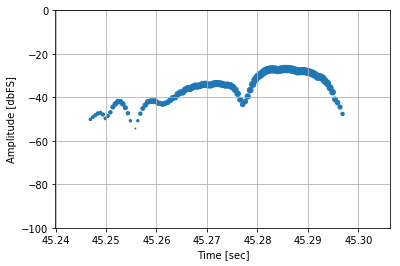

In [8]:
sizes = [(x+abs(min(result_y_max)))**1.2 for x in result_y_max]
plt.scatter(result_x_sec, result_y_max, s=sizes)
plt.grid(True)
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude [dbFS]')
plt.ylim((-100,0))
plt.show()


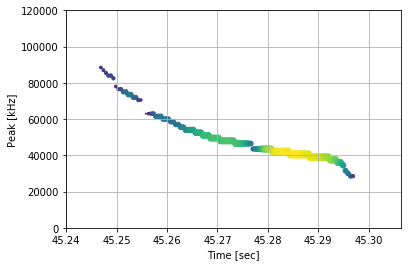

In [9]:
sizes = [(x+abs(min(result_y_max)))**1.2 for x in result_y_max]
plt.scatter(result_x_sec, result_y_peak, s=sizes, c=sizes)
#plt.summer()
#plt.winter()
#plt.autumn()
plt.viridis()
#plt.gray()
plt.grid(True)
plt.xlabel('Time [sec]')
plt.ylabel('Peak [kHz]')
plt.ylim((0,120000))
plt.show()


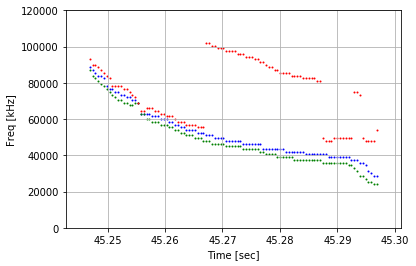

In [10]:
plt.scatter(result_x_sec, result_y_peak, marker='o', s=1, color='b')
plt.scatter(result_x_sec, result_y_minfr, marker='o', s=1, color='g')
plt.scatter(result_x_sec, result_y_maxfr, marker='o', s=1, color='r')

plt.grid(True)
plt.xlabel('Time [sec]')
plt.ylabel('Freq [kHz]')
plt.ylim((0,120000))
plt.show()
